In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy import stats

import emcee
from astroML.plotting import plot_mcmc


# These defaults are the ones I like, but feel free to adapt them
sns.set_style('white')
sns.set_context('talk')


# Exercises on Bayesian statistics and inference
These are exercises belonging to the workshop material on Bayesian statistics and inference "Bayesian Statistics: the what, the why, and the how". I leave it totally up to you whether you do any if this or not. In the Solutions notebook you will find one way to tackle the problems posed here. Most, if not all, problems can be solved in a plethora of ways. Feel free to experiment around, it will only teach you more in the end.

## 1) Testing positively to a serious disease

Here are the equations for the disease testing exercise. Plug in some numbers and play around if you like.

In [2]:
P_positive_if_ill = .99
P_positive_if_notill = .01
P_ill = 1.e-3


def P_ill_if_positive(P_positive_if_ill=.99, P_positive_if_notill=.01, P_ill=1.e-3):
    """Function that simply plugs the numbers into Bayes' theorem"""
    P_notill = 1 - P_ill
    return P_positive_if_ill * P_ill / (P_positive_if_ill * P_ill + P_positive_if_notill * P_notill )

In [3]:
# Feel free to play around with these numbers!
print(P_ill_if_positive(P_positive_if_ill=.99, P_positive_if_notill=.01, P_ill=1.e-3))

0.09016393442622951


Questions you could ask yourself are:
- What number would the pharmaceutical industry like to see optimized compared to the example? 

*The false positive rate is crucial. Add some zeros to that and the probability goes up quickly, while adding nines to the true positive rates does little, see below.*
- Most people guess a much higher probability than 0.09 when given the question. What aspect are they forgetting about, and how/where does this appear in Bayes' theorem? 

*The false positive rate is easily forgotten, this is part of the denominator.*
- What happens when you forget the terms about false positives? 

*Your denominator will equal the numerator, giving a probability of 1, regardless of any of the other numbers, which is clearly wrong.*
- Investigate the dependence of the posterior probability graphically.

*For an example, see below.*


In [4]:
# If the true positive rate goes up, numbers hardly change:
print("P with a true positive rate of 0.9999:", P_ill_if_positive(P_positive_if_ill=.9999, P_positive_if_notill=.01, P_ill=1.e-3))
# While lowering the false positive rate can make results change quickly:
print("P with a false positive rate of 0.001 and 0.0001:", P_ill_if_positive(P_positive_if_ill=.99, P_positive_if_notill=.001, P_ill=1.e-3), 
      P_ill_if_positive(P_positive_if_ill=.99, P_positive_if_notill=.0001, P_ill=1.e-3))


P with a true positive rate of 0.9999: 0.09098353943165997
P with a false positive rate of 0.001 and 0.0001: 0.49773755656108587 0.9083402146985962


In graphs:


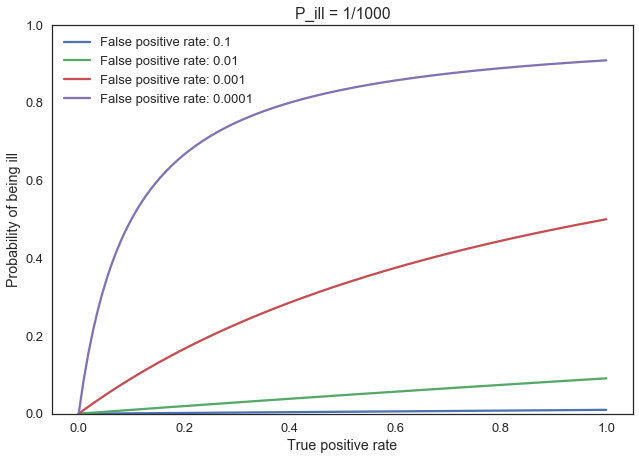

In [5]:
print("In graphs:")
posrates = 1-( 10**-(np.arange(1000)/250))
for fp in [.1, 0.01, 0.001, 0.0001]:
    pvals = [P_ill_if_positive(pos, P_positive_if_notill=fp) for pos in posrates]
    plt.plot(posrates, pvals, label="False positive rate: "+str(fp))
plt.xlabel("True positive rate")
plt.ylabel("Probability of being ill")
plt.title("P_ill = 1/1000")
plt.ylim([1e-5,1])
# plt.semilogy()
# plt.semilogx()
plt.legend();

## 2) Updating one's knowledge of a system

Given the numbers in the original example, as stated above, how many positive tests do you need to get before your certainty about being ill rises above 99%? 
It's probably easiest to write a while-loop (or a for-loop with a break statement) in which Bayes' theorem is used to update the knowledge with the new data every time.

In [6]:
newprob = 1.e-3
ii = 0
threshold = 0.99
while newprob < threshold:
    print("After test", ii, "the probability is", newprob)
    newprob = P_ill_if_positive(P_positive_if_ill=.99, P_positive_if_notill=.01, P_ill=newprob)
    ii += 1
print("Threshold probability", threshold, "reached after", ii, "tests:", newprob)

After test 0 the probability is 0.001
After test 1 the probability is 0.09016393442622951
After test 2 the probability is 0.9075000000000001
Threshold probability 0.99 reached after 3 tests: 0.9989714794017902


## 3) A world of Gaussians

For the situation where we try to determine the mean flux of that star, while it is itself fluctuating in brightness, please recreate the sampler, try to do so from scratch, but if that is too much to ask, then find some inspiration in the notebook.

If that works well: try the following:
- Play with the number of walkers. Does it make much of a difference if you use only one (hint: emcee will tell you!)?
- Try to not use a flat prior, but a very wide Gaussian for the mean, still flat for the standard deviation. Try this with the gaussian centered at the "correct" value, and with Gaussians that do include the correct value at a low but non-zero number of standard deviations from the correct values and one that is far off. Discuss outcomes! It may help to make the intrinsic distribution of fluxes wider (and/or the sample really small).


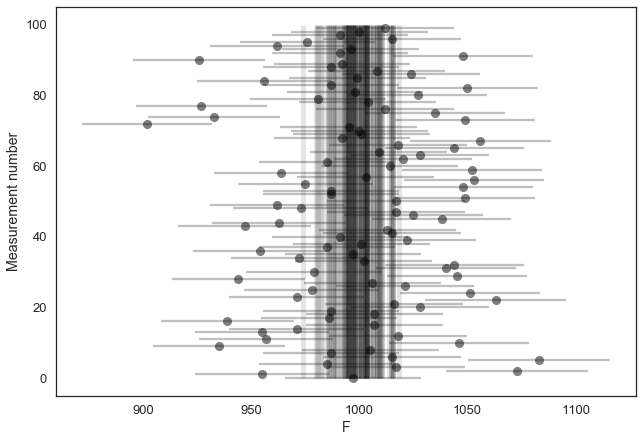

In [7]:
# First, here's the code that generates the data set:
np.random.seed(42)  
N = 100  
mu_true, sigma_true = 1000, 10  # True flux at time of measurement is distributed following a gaussian.

F_true = stats.norm(mu_true, sigma_true).rvs(N)  # Onbekende werkelijke aantallen, nu met scatter
F = stats.poisson(F_true).rvs()  # Waargenomen aantallen, met errors
e = np.sqrt(F)  # root-N error

# For the visual, a graph of that:
fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.1)
ax.set_xlabel("F");ax.set_ylabel("Measurement number");

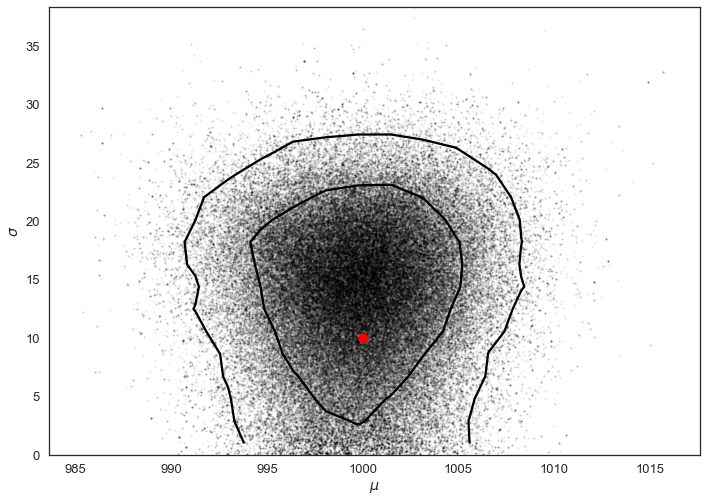

In [8]:
# The likelihood, prior and resulting posterior:
def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * (theta[1] ** 2 + e ** 2))
                         + (F - theta[0]) ** 2 / (theta[1] ** 2 + e ** 2))

def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# Setting up the emcee run
ndim, nwalkers = 2, 10
nsteps, nburn = 20000, 1000   # You might want/need to check the number of burners for some cases!

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 200
starting_guesses[:, 1] *= 50    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)


# Show the posterior contours and the "correct" value:
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

fig = plt.figure()
ax = plot_mcmc(sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], colors='k', )
ax[0].plot(sample[:, 0], sample[:, 1], '.k', alpha=0.1, ms=4)
ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10);


*Making plots of the posterior for different numbers of walkers should show it doesn't matter much. It might matter a lot more with bi- or multimodal posteriors!!*

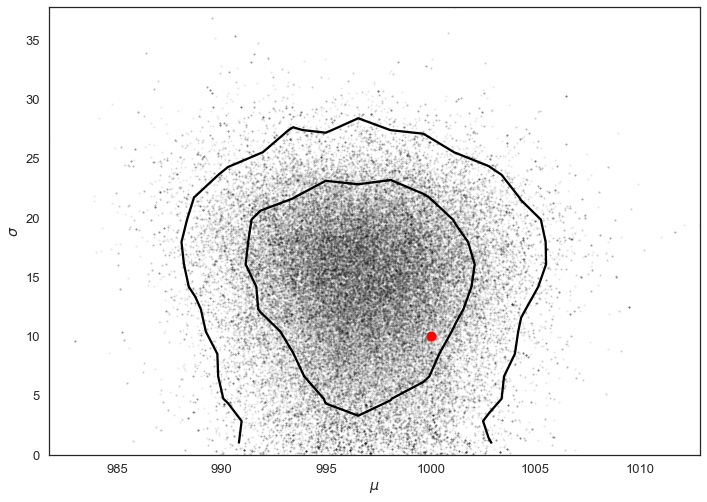

In [9]:
# A gaussian prior, centered at the correct values:
# Just to see the difference I call this gprior, for gaussian prior. 
# Therefore, I have to change the posterior definition as well. Usualy you won't do this.
def log_gprior(theta):
    center = 900
    width = 20
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        # I use a Gaussian centered at "center" and with a sigma of "width", play with variations!
        # A flat prior in sigma, means that the prior is independent of the value of sigma (=theta[1])
        # (the posterior still depends on through the likelihood!)
        return -0.5 * (np.log(2 * np.pi * width ** 2) + ( (center - theta[0]) ** 2 / width ** 2))

def log_posterior(theta, F, e):
    return log_gprior(theta) + log_likelihood(theta, F, e)

    
# Other functions can remain unchanged
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 500   # You might want/need to check the number of burners for some cases!

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 200
starting_guesses[:, 1] *= 50    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)


# Show the posterior contours and the "correct" value:
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

fig = plt.figure()
ax = plot_mcmc(sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], colors='k', )
ax[0].plot(sample[:, 0], sample[:, 1], '.k', alpha=0.1, ms=4)
ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10);


## 4) The linear fit with outliers, with outliers.

In the notebook we saw how to fit a slope and intercept to points with errors in the vertical direction. We reproduce the data set here:

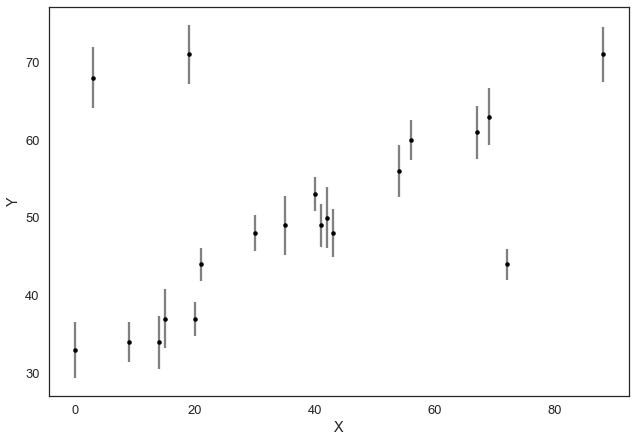

In [10]:
x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])
e = np.array([ 3.6, 3.9, 2.6, 3.4, 3.8, 3.8, 2.2, 2.1, 2.3, 3.8,
               2.2, 2.8, 3.9, 3.1, 3.4, 2.6, 3.4, 3.7, 2.0, 3.5])

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.xlabel('X');plt.ylabel('Y');

As a reminder, we will give the definition of the likelihood, which is a bit complicated, and the definition of the posterior, we leave the definition of the prior to you! Do make sure to check if you understand the likelihood function!

In [11]:
def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)

The definition of the posterior shows what will need to go into the prior and what comes. What is it? 
Also define the prior as a function. Think of the allowed parameter ranges, don't cheat and look the solutions notebook.

*The prior is the pdf of the model parameters before the new data. It should therefore return a probability density for a given set of 22 parameter ingredients, the slope, intercept, and 20 nuisance weights*.

In [12]:
def log_prior(theta):
    #g_i needs to be between 0 and 1
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  # log(0) = -inf


Now let's run the MCMC, in the same set-up as in the notebook, to make sure we get the weird points:

In [13]:
ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take


# set theta near the maximum likelihood, with 

from scipy import optimize

def squared_loss(theta, x=x, y=y, e=e):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / e) ** 2)

theta1 = optimize.fmin(squared_loss, [0, 0], disp=False)


np.random.seed(42)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e, 50])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

/home/marcel/anaconda3/envs/workshop/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/home/marcel/anaconda3/envs/workshop/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


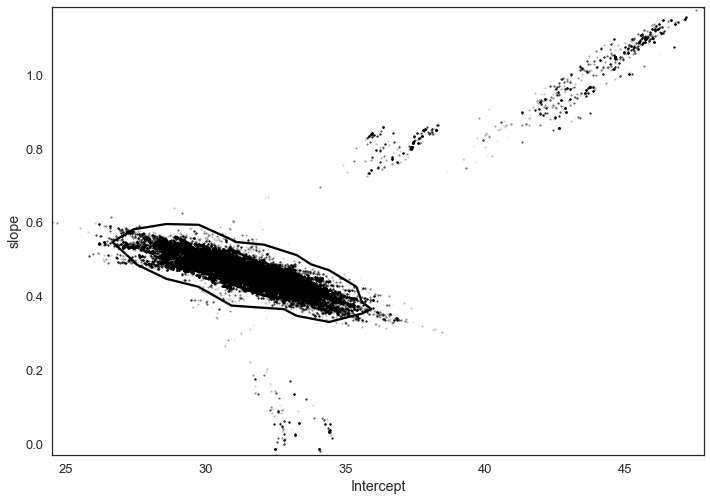

In [14]:
fig = plt.figure()
ax = plot_mcmc(sample[:,:2].T, fig=fig, labels=[r'Intercept', r'slope'], colors='k')
ax[0].plot(sample[:, 0], sample[:, 1], '.k', alpha=0.1, ms=4);
ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10);

Investigate the attributes that come with teh sampler object. Is there any way in which you can assess the evolution of the sampled posterior probability density? What does it look like? You probably want to investigate the evolution of that pdf along all the walkers.

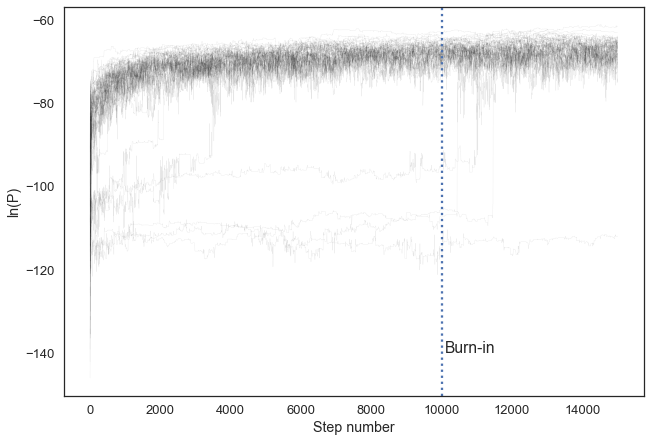

In [15]:
# sampler.lnprobability gives the log probability of the points in tha sampler. THe evolve as follows:

# Let's have a look at all the walkers and a choice of the burn in
for i in range(len(sampler.lnprobability)):
    plt.plot(sampler.lnprobability[i,:], linewidth=0.3, color='k', alpha=0.1)
plt.ylabel('ln(P)')
plt.xlabel('Step number')
plt.axvline(x=nburn, linestyle='dotted')
plt.text(nburn*1.01, -140, "Burn-in");

If you happen to run this with a different radom number seed, most likely you find no deviant points. Somehow, this particular walker took very long to get the equilibrium region where it should be sampling. Always check if your choice of burn-in period seems appropriate!

In [16]:
import numpy as np
np.exp(2)

7.3890560989306504

## 5) Truncated exponentials the numeric way

We have seen the Jaynes' truncated exponential in the instruction notebook. We have found an analytical way to come up with the 95% confidence interval. Because we like numerical sampling, let's have a try and construct an MCMC sampling of this posterior and get the 95% confidence interval numerically.

In previous exercises, the posterior was built up out of a prior and a likelihood. The prior in this case can be taken flat, with the "common sense" cut-off ($\theta < min(D)$). For the likelihood we just use the prescription the whole section started with. A function that is linearly proportional to the posterior was found by skipping over some mathematics involving the convolution theorem and characteristic functions:

$$
p(\theta~|~D) \propto \left\{
\begin{array}{lll}
N\exp\left[N(\theta - \min(D))\right] &,& \theta < \min(D)\\
0                &,& \theta > \min(D)
\end{array}
\right\}
$$

in which $N$ is the number of elements in the vector of data points $D$. $\theta$  conveniently is just one number. The posterior should be a one-dimensional pdf of values of $\theta$. Let's define this and set up the MCMC run:

In [17]:
def log_posterior(theta, D):
    if theta > min(D): return -np.inf
    else: return np.log((len(D) * np.exp( len(D)*(theta - min(D)) )))

D = [10, 12, 15]
    
ndim = 1
nwalkers = 50
nsteps = 2000

starting_guesses = 20 * np.random.rand(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[D])
sampler.run_mcmc(starting_guesses, nsteps)

nburn = 100 # Or pick something you like, or find reasonable...

sample = sampler.chain[:, nburn:, :].ravel()

p3, p98 = np.percentile(sample, [2.5, 97.5])
print("The 95% credible region is ({0:.3f} - {1:.3f})".format(p3, p98))

/home/marcel/anaconda3/envs/workshop/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/marcel/anaconda3/envs/workshop/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


The 95% credible region is (8.890 - 19.543)


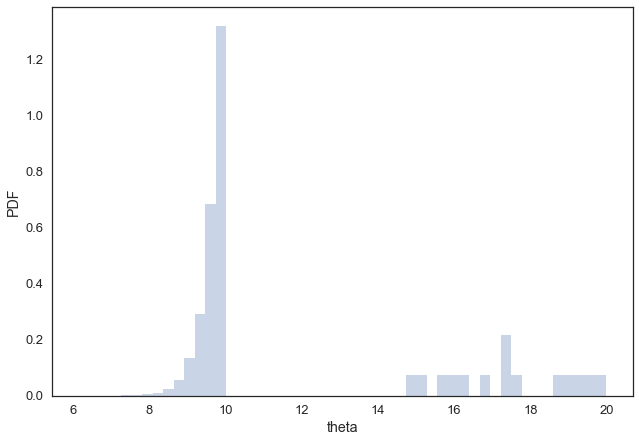

In [18]:
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, normed=True)
plt.xlabel("theta"); plt.ylabel("PDF")


You may notice that there are valus for $\theta$ in the sample that are higher than the common sense upper limit (likely). Investigate if your burn-in period is taken long enough. Can there be other explanations?

Clean up your sample after burn in by discarding points that have an infintely low probabiilty (the attributes of the sample that is the result of the MCMC run should have some hints) and estimate the 95% credible region again.

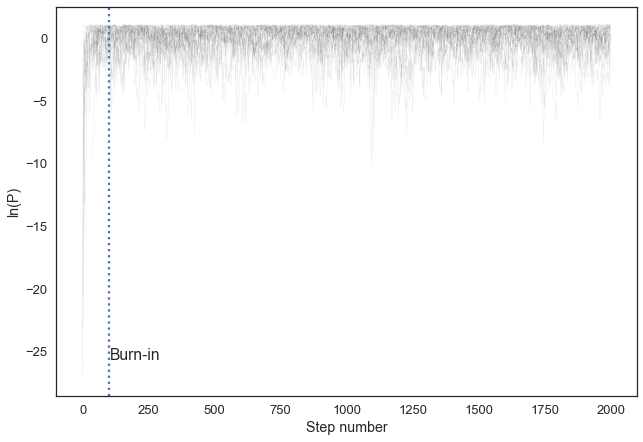

In [19]:
for i in range(len(sampler.lnprobability)):
    plt.plot(sampler.lnprobability[i,:], linewidth=0.3, color='k', alpha=0.1)
plt.ylabel('ln(P)')
plt.xlabel('Step number')
plt.axvline(nburn, linestyle='dotted')
plt.text(nburn*1.01, plt.ylim()[0]*.9, "Burn-in");

The 95% credible region is (8.769 - 9.992)
An argument could be made for having the 95% C.R. runs from the 5th percentile to the maximum:
(8.995-10)
That reproduces the analytic solution from the instruction notebook.


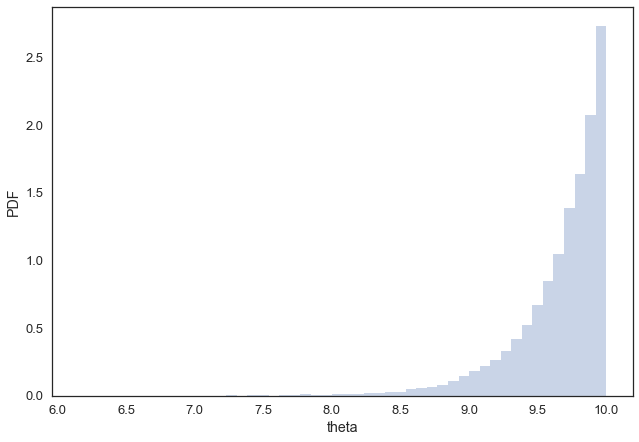

In [20]:
probs = sampler.lnprobability[:, nburn:].ravel()
sample = (sampler.chain[:, nburn:, :].ravel())[probs > -np.inf]

p3, p98 = np.percentile(sample, [2.5, 97.5])
print("The 95% credible region is ({0:.3f} - {1:.3f})".format(p3, p98))

plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, normed=True)
plt.xlabel("theta"); plt.ylabel("PDF");

print("An argument could be made for having the 95% C.R. runs from the 5th percentile to the maximum:")
print("({0:.3f}-10)".format(np.percentile(sample, 5)))
print("That reproduces the analytic solution from the instruction notebook.")

One thing to learn from this, is that **you should be careful with sharp edges in your posterior PDF**.

## If you have some time left...

Think of your own work. Where would it all fit in? Do you maximize likelihood functions every once in a while? And if so: do you actually have prior knowledge you would like to take into account? Are there nuisance parameters that you ignore and just pick some value for because that made the statistics easier? 